In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

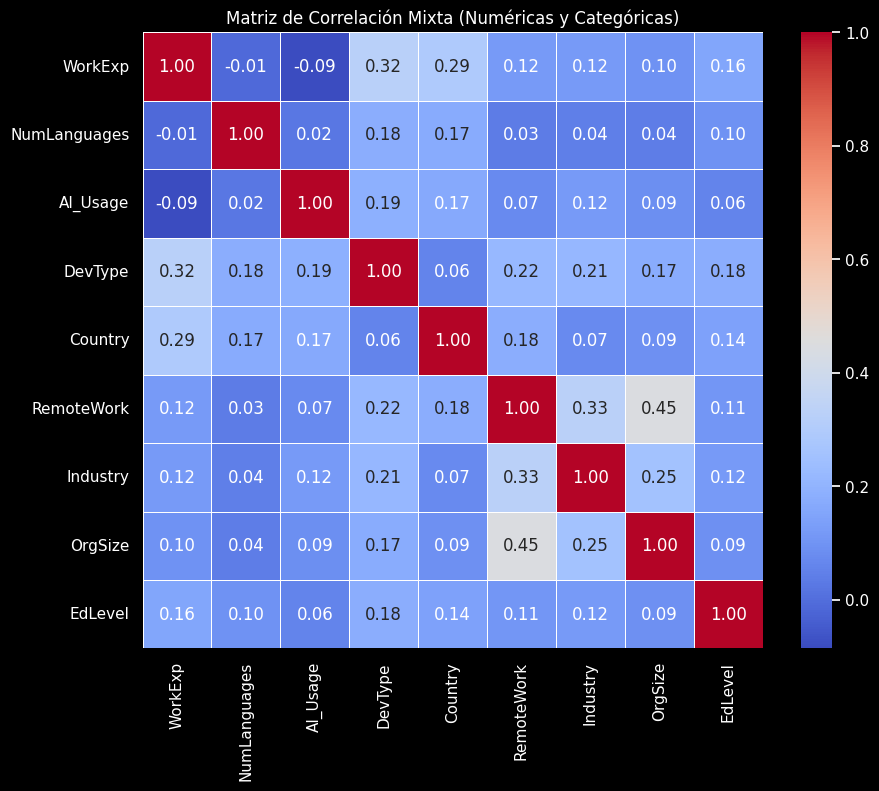

<Figure size 640x480 with 0 Axes>

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


# --- Configuración modo oscuro ---
plt.style.use("dark_background")
sns.set_theme(style="darkgrid")
sns.set(rc={
    "axes.facecolor": "#111111",
    "figure.facecolor": "#000000",
    "axes.edgecolor": "#444444",
    "grid.color": "#333333",
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white"
})

# Cargar dataset
df = pd.read_csv("data/processed/survey_ai_usage_clean_filtered.csv")

# Separar variables
cat_cols = ["DevType", "Country", "RemoteWork", "Industry", "OrgSize", "EdLevel"]
num_cols = ["WorkExp", "NumLanguages", "AI_Usage"]

# --- Funciones auxiliares ---

# Cramer's V para categóricas ↔ categóricas
def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    phi2 = chi2 / n
    r, k = confusion.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Correlation ratio η para numéricas ↔ categóricas
def correlation_ratio(categories, values):
    fcat, _ = pd.factorize(categories)
    cat_means = [values[fcat == i].mean() for i in range(len(np.unique(fcat)))]
    overall_mean = values.mean()
    numerator = sum([len(values[fcat == i]) * (cat_means[i] - overall_mean)**2 for i in range(len(cat_means))])
    denominator = sum((values - overall_mean)**2)
    return np.sqrt(numerator / denominator) if denominator != 0 else 0

# --- Calcular matriz mixta ---
cols = num_cols + cat_cols
corr_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)

for col1 in cols:
    for col2 in cols:
        if col1 == col2:
            corr_matrix.loc[col1, col2] = 1.0
        elif col1 in num_cols and col2 in num_cols:
            corr_matrix.loc[col1, col2] = df[[col1, col2]].corr(method="spearman").iloc[0,1]
        elif col1 in cat_cols and col2 in cat_cols:
            corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
        else:
            # uno numérico y otro categórico
            if col1 in cat_cols:
                corr_matrix.loc[col1, col2] = correlation_ratio(df[col1], df[col2])
            else:
                corr_matrix.loc[col1, col2] = correlation_ratio(df[col2], df[col1])

# --- Visualización ---
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación Mixta (Numéricas y Categóricas)")
plt.show()
plt.savefig("docs/assets/charts/mixed_correlation_matrix.png", bbox_inches='tight')

| Tipo                           | Variables sugeridas   | Justificación                                                     |
| ------------------------------ | --------------------- | ----------------------------------------------------------------- |
| **Profesional**                | `DevType`             | Fuerte asociación con el uso de IA.                               |
| **Geográfica**                 | `Country`             | Influye moderadamente (acceso a tecnología).                      |
| **Sectorial / Organizacional** | `Industry`, `OrgSize` | Diferencias en adopción por tamaño y sector.                      |
| **Experiencia**                | `WorkExp`             | Aporta contraste entre junior/senior.                             |
| **Educativa**                  | `EdLevel`             | Contextual (poca correlación pero interpretativamente relevante). |


In [4]:
df = pd.read_csv("data/processed/survey_ai_usage_clean_filtered.csv")
df.shape

(33065, 10)

In [6]:
df['AI_Usage'].value_counts()

AI_Usage
1    26107
0     6958
Name: count, dtype: int64

In [7]:
(df == "No especificado").mean().sort_values(ascending=False)


RemoteWork                0.206623
OrgSize                   0.200363
Industry                  0.119704
LanguageHaveWorkedWith    0.083472
EdLevel                   0.002147
DevType                   0.000000
WorkExp                   0.000000
Country                   0.000000
AI_Usage                  0.000000
NumLanguages              0.000000
dtype: float64

In [8]:
subset = df[df != "No especificado"].dropna()
subset['AI_Usage'].value_counts(normalize=True)


AI_Usage
1    0.800538
0    0.199462
Name: proportion, dtype: float64